<a href="https://colab.research.google.com/github/brianp0513/NLP-project/blob/main/LSTM_NLP_Project_version2_with_K_fold_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer

# import seaborn as sns
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import random
import os
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def getTextFromFiles(df, data_path, depression, limit):
    """Return Data Frame """

    for file in os.listdir(data_path)[:limit]:
        with open(data_path + "/" + file, 'r', encoding="ISO-8859-1") as file1:
            file1 = file1.read()
            df = df.append({'text': file1, 'depression': int(depression)}, ignore_index=True)

    return df

# test dataset 읽기
def getTextFromFiles_Test(df_test, data_path, limit):
    """Return Data Frame """

    for file in os.listdir(data_path)[:limit]:
        with open(data_path + "/" + file, 'r', encoding="ISO-8859-1") as file1:
            file1 = file1.read()
            df_test = df_test.append({'text': file1}, ignore_index=True)

    return df_test

In [ ]:
def dataPreprocessingForX(df, columnName1):
  #   읽어들인 데이터를 모두 소문자화 시킨다
  df[columnName1] = df[columnName1].map(lambda text: text.lower())
  # 단어 단위로 나눈다(word tokenzing)
  df[columnName1] = df[columnName1].map(lambda text: nltk.tokenize.word_tokenize(text))
  # stoptwords를 이용하여 불필요한 단어 제거
  stop_words = set(nltk.corpus.stopwords.words('english'))
  df[columnName1] = df[columnName1].map(lambda tokens: [w for w in tokens if not w in stop_words])
  # regular expression을 이용한 특수문자 제거
  df[columnName1] = df[columnName1].map(lambda text: ' '.join(text))
  df[columnName1] = df[columnName1].map(lambda text: re.sub('[^A-Za-z]+', ' ', text))
  # word stemmer를 톨해 단어를 원문화 시킨다.
  df[columnName1] = df[columnName1].map(lambda text: nltk.tokenize.word_tokenize(text))
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()
  # print(df[columnName1][0])
  df[columnName1] = df[columnName1].map(lambda text: [lemmatizer.lemmatize(i) for i in text])
  df[columnName1] = df[columnName1].map(lambda text: ' '.join(text))

# 파일이 제대로 읽혔는지 확인하는 function
def checkfilesCounts(data_path):
    print(data_path+" have: ", len(os.listdir(data_path)),"files")

# 개인 pc에서 실행시
# data_path_d = "reddit_depression"
# data_path_nd = "reddit_non_depression"
# data_path_d_test = "reddit_depression_testset"
# collab에서 실행시
data_path_d = "/content/drive/My Drive/NLP Team/code/kerasData/reddit_depression"
data_path_nd = "/content/drive/My Drive/NLP Team/code/kerasData/reddit_non_depression"

checkfilesCounts(data_path_d)
checkfilesCounts(data_path_nd)
#
# # 데이터 전처리
df = pd.DataFrame(columns=['text', 'depression'])
df = getTextFromFiles(df, data_path_d, 1, 500)


/content/drive/My Drive/NLP Team/code/kerasData/reddit_depression have:  1293 files
/content/drive/My Drive/NLP Team/code/kerasData/reddit_non_depression have:  548 files


In [ ]:
# # 이시점까진 우울증 글만 추가
df = getTextFromFiles(df, data_path_nd, 0, 500)
dataPreprocessingForX(df, 'text')

df['depression'] = df['depression'].astype('int32')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Non depression and depression messages')

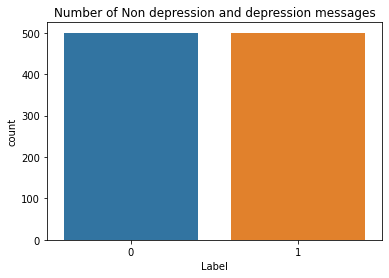

In [ ]:

sns.countplot(df['depression'])
plt.xlabel('Label')
plt.title('Number of Non depression and depression messages')

In [ ]:
X = df['text'].to_numpy()
Y = df['depression'].to_numpy()
# le = LabelEncoder()
# Y = le.fit_transform(Y)
# Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

max_words = 100
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
print(X_train.shape)
print(sequences)
print(sequences_matrix.shape)

(850,)
[[11, 8, 13, 4, 90, 3, 90, 3, 6, 13, 4, 90, 3, 6, 13, 4, 1, 29, 8, 13, 4, 25, 6, 1, 19, 17, 6, 90, 3, 6, 61, 13, 4, 10, 11, 67, 1, 9], [10, 2, 1, 4, 87, 9, 3, 34, 4, 14, 28, 28, 80, 15, 14, 64, 23, 31, 39, 8, 22, 55, 38, 11, 83, 97, 33, 2, 1, 12, 83, 14, 97, 64, 5, 48, 48, 14, 10, 3, 27, 37, 30, 97, 76, 72, 32, 54, 3, 76, 65, 55, 2, 1, 10, 2, 1, 10, 23, 31, 12, 68, 72, 87, 14, 2, 1, 7, 6, 57, 3, 19, 59, 97, 48, 97, 5, 2, 1, 10, 12, 43, 88, 14, 31, 39, 8, 4, 2, 1, 83, 97, 3, 3, 2, 1, 16, 9, 4, 72, 3, 88, 15, 10, 2, 1, 72, 14, 18, 23, 30, 2, 1, 10], [52, 5, 12, 96, 5, 14, 34, 8, 12, 92, 3, 39, 8, 92, 3, 76, 43, 81, 89, 44, 15, 29, 23, 12, 60, 20, 88, 27, 4, 4, 92, 22, 2, 1, 7, 6, 4, 4, 5, 10], [5, 4, 87, 60, 4, 83, 20, 23, 44, 5, 20, 78, 81, 11, 75, 12, 18, 2, 1, 94, 83, 33, 81, 43, 2, 1, 35, 83, 43, 4, 35, 83, 35, 2, 1, 6, 9, 59, 11, 56, 59, 6, 75, 3, 2, 1, 37, 2, 1, 78, 4, 73, 6, 66, 66, 5, 84, 20, 2, 1, 6, 93, 11, 54, 8, 8, 3, 11, 2, 1, 44, 43, 2, 1, 57, 43, 20, 7, 87, 2, 1, 33

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

5-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Input Data
X = df['text'].to_numpy()
Y = df['depression'].to_numpy()
# le = LabelEncoder()
# Y = le.fit_transform(Y)
# Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

max_words = 100
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

batch_size = 4
no_epochs = 10
verbosity = 0

num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Data format matching
  tok = Tokenizer(num_words=max_words)
  tok.fit_on_texts(inputs[train])
  sequences = tok.texts_to_sequences(inputs[train])
  sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

  # Define the model architecture
  model = RNN()
  model.summary()
  
  # Compile the model
  model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Fit data to model
  history = model.fit(sequences_matrix, targets[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity)
  
  # model.fit(sequences_matrix,Y_train,batch_size=4,epochs=10,
  #         validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
  # test_sequences = tok.texts_to_sequences(X_test)
  # test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


  # Data format matching
  test_sequences = tok.texts_to_sequences(inputs[test])
  test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
  

  # Generate generalization metrics
  # accr = model.evaluate(test_sequences_matrix,Y_test)
  # print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

  scores = model.evaluate(test_sequences_matrix, targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 150, 50)           5000      
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)               

+ Deep Learning - RNN with LSTM

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
# model = tf.keras.models.Sequential()
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           5000      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=4,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
170/170 [==============================] - 9s 54ms/step - loss: 0.6367 - accuracy: 0.6588 - val_loss: 0.4909 - val_accuracy: 0.7471
Epoch 2/10
170/170 [==============================] - 9s 55ms/step - loss: 0.5461 - accuracy: 0.8235 - val_loss: 0.6587 - val_accuracy: 0.7412


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.5881 - accuracy: 0.8200


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.588
  Accuracy: 0.820


In [ ]:
from keras.preprocessing.text import Tokenizer

text = 'Yours and mine ancestors had run after a mastodons or wild boar, like an olympic sprinter, with a spear in hand covering themselves with leaves and tiger skin, for their breakfast'

tokemizer = Tokenizer(num_words = 30) # numwords is number of top common words to take. Rest words are marked as all 0s for one-hot
tokemizer.fit_on_texts(text)
print(tokemizer.word_index)

print(tokemizer.texts_to_matrix(text[0].split(),mode='binary'))

{'a': 1, 'e': 2, 'r': 3, 's': 4, 'n': 5, 'i': 6, 't': 7, 'o': 8, 'd': 9, 'h': 10, 'l': 11, 'm': 12, 'c': 13, 'f': 14, 'w': 15, 'k': 16, 'p': 17, 'v': 18, 'y': 19, 'u': 20, 'b': 21, 'g': 22}
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
